In [248]:
from collections import Counter
from abc import ABC, abstractclassmethod, abstractmethod

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.max_rows",4999)

In [66]:


class FederalRates(ABC):
    
    def __init__(self, fundRate, fundRate_2):
        try: 
            self.fundRate = fundRate
            self.fundRate_2 = fundRate_2
            super(FederalRates, self).__init__()
        except AttributeError as e:
            print(e)
            
    @abstractmethod
    def predict(self):
        return self.__init__() 
    
    @abstractmethod
    def testValues(self):
        return self.__init__() 

    @classmethod
    def readData(cls, path):
        rawData = pd.read_csv(path)
        return (rawData)


        


In [68]:
def describes(rawInterestRateData, rawInflationRateData):
    testInterestRate = TestInterestRate(FederalRates.readData(rawInterestRateData), 0)
    return print(testInterestRate.predict())

describes("./FF.csv",0)

count    99.000000
mean      2.018485
std       0.346099
min       1.370000
25%       1.700000
50%       2.120000
75%       2.390000
max       2.440000
Name: FF, dtype: float64


# Forecasting Fund Rates with Our Dataset with Auto regressive Model #

*** Please note that in this prediction model other parameters like CPI, SMPI, II and Sentimental Analytics are not included. This is only to demonstrate and forecasting future values by applying given model. ***

### What is an ARIMA model? ###

Arima model is a class of statistical models for analyzing and forecasting time series since our variable is depending on the time.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

**ARIMA** is an acronym that stands for **AutoRegressive Integrated Moving Average**. It is a generalization of the simpler **AutoRegressive Moving Average** and adds the notion of integration.

1) **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

2) **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

3) **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

### Describing our equation ###

Our main purpose is to predict from ŷ to y value. for this we need to create matrix design which part of the geometric series. It would be much better to review and understand the behavior of the partial derivates, newtons method and geometric series.

**ŷt   =   μ + ϕ1 yt-1 +…+ ϕp yt-p - θ1et-1 -…- θqet-q**

1) To identify the appropriate ARIMA model for Y, you begin by determining the order of differencing (d) needing to stationarize the series and remove the gross features of seasonality, perhaps in conjunction with a variance-stabilizing transformation such as logging or deflating. 

2) If you stop at this point and predict that the differenced series is constant, you have merely fitted a random walk or random trend model. However, the stationarized series may still have autocorrelated errors, suggesting that some number of AR terms (p ≥ 1) and/or some number MA terms (q ≥ 1) are also needed in the forecasting equation.


In [244]:

class ArInterestRate(FederalRates):
    
    def filtered(self):
        rawInterestRate = self.fundRate["DATE"] > "2019-04-15"
        return self.fundRate[rawInterestRate].set_index("DATE")
    
    def predict(self):
        interestRate = self.filtered()["FF"]    
        freqTable = dict(Counter(interestRate))
        return interestRate .describe()
        
    def StartARIMAForecasting(self, Actual, P, D, Q):
        """
            P — Auto regressive feature of the model
            D — Differencing order
            Q — Moving average feature of the model

        """
        model = ARIMA(Actual, order=(P, D, Q))
        model_fit = model.fit(disp=0)
        prediction = model_fit.forecast()[0]
        return prediction
    
    def testValues(self):
        values = self.filtered()["FF"]
        #predict next value
        predicted = self.StartARIMAForecasting(values, 3,1,0)

        #Use 70% of data as training, rest 30% to Test model
        NumberOfElements = len(values)
        TrainingSize = int(NumberOfElements * 0.7)
        TrainingData = values[0:TrainingSize]
        TestData = values[TrainingSize:NumberOfElements]

        #new arrays to store actual and predictions
        Actual = [x for x in TrainingData]
        Predictions = list()
        Predictions2 = list()


        #in a for loop, predict values using ARIMA model
        for timepoint in range(len(TestData)):
            ActualValue =  TestData[timepoint]
            #forcast value
            Prediction = self.StartARIMAForecasting(Actual, 2,1,0)# second order auto regression    
            print("\n Degree 2\n",'Actual=%f, Predicted=%f' % (ActualValue, Prediction))
            #add it in the list
            Predictions.append(Prediction)
            Prediction2 = self.StartARIMAForecasting(Actual, 3,1,0)# second order auto regression    
            print("\n Degree 3\n",'Actual=%f, Predicted=%f' % (ActualValue, Prediction2))
            #add it in the list
            Predictions2.append(Prediction2)
            Actual.append(ActualValue)
    

        #Print MSE to see how good the model is
        Error = mean_squared_error(TestData, Predictions)
        print('\n Test Mean Squared Error (smaller the better fit): %.3f' % Error)
        # plot
        plt.subplots(figsize=(19, 8))
        plt.plot(TestData)
        plt.plot(Predictions, color='red')
        plt.plot(Predictions2, color='green', linestyle="dashed")
        plt.xticks(rotation=45)

        plt.show()
        
        
        
        
        
                


### Executing our dataset ###

/Users/sadikerisen/opt/anaconda3/envs/forecastingInterestRate/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/Users/sadikerisen/opt/anaconda3/envs/forecastingInterestRate/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)



 Degree 2
 Actual=2.190000, Predicted=2.111933

 Degree 3
 Actual=2.190000, Predicted=2.112293

 Degree 2
 Actual=1.900000, Predicted=2.179324

 Degree 3
 Actual=1.900000, Predicted=2.181070

 Degree 2
 Actual=1.850000, Predicted=1.924544

 Degree 3
 Actual=1.850000, Predicted=1.926389

 Degree 2
 Actual=1.820000, Predicted=1.890358

 Degree 3
 Actual=1.820000, Predicted=1.885929

 Degree 2
 Actual=1.840000, Predicted=1.799388

 Degree 3
 Actual=1.840000, Predicted=1.825350

 Degree 2
 Actual=1.850000, Predicted=1.814870

 Degree 3
 Actual=1.850000, Predicted=1.817247

 Degree 2
 Actual=1.830000, Predicted=1.821633

 Degree 3
 Actual=1.830000, Predicted=1.821188

 Degree 2
 Actual=1.570000, Predicted=1.805261

 Degree 3
 Actual=1.570000, Predicted=1.799348

 Degree 2
 Actual=1.550000, Predicted=1.558184

 Degree 3
 Actual=1.550000, Predicted=1.557354

 Degree 2
 Actual=1.550000, Predicted=1.557539

 Degree 3
 Actual=1.550000, Predicted=1.559923

 Test Mean Squared Error (smaller the b

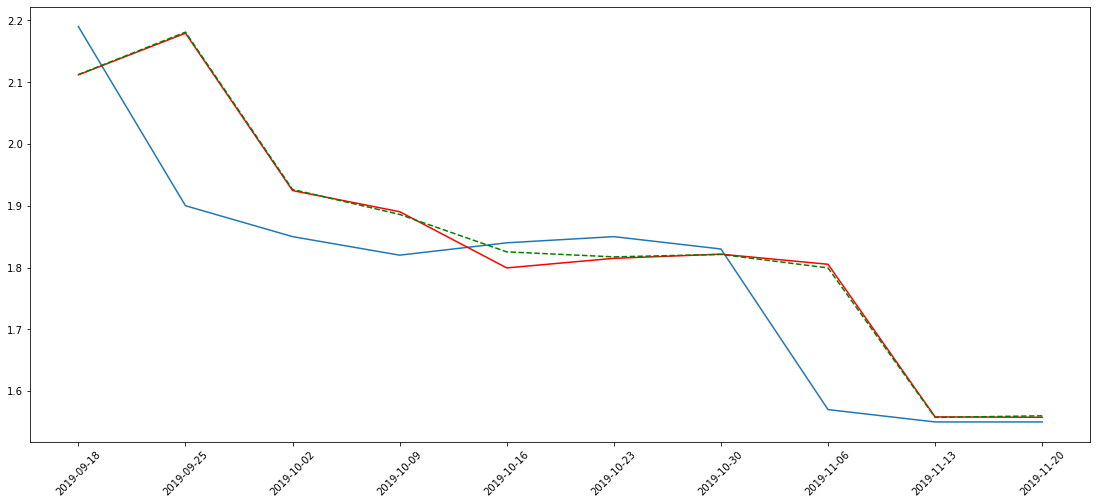

In [245]:
def test(rawInterestRateData):
    testInterestRate = ArInterestRate(FederalRates.readData(rawInterestRateData), 0)
    return testInterestRate.testValues()


test("./FF.csv")

# Forecasting Fund Rates with Our Dataset with Linear Regression #

### what is linear regression ###
Regression searches for relationships among variables.

For example, you can observe several employees of some company and try to understand how their salaries depend on the features, such as experience, level of education, role, city they work in, and so on.

This is a regression problem where data related to each employee represent one observation. The presumption is that the experience, education, role, and city are the independent features, while the salary depends on them.

in our demonstration we are applying single variable to train our machine and come up with result. our mathematical equation is same we still have to use serie concept respect to the y axis. 

On the final step is to evaluate the performance of algorithm we apply the values for **MAE, MSE and RMSE**.

1) Need more data: Only one year worth of data isn't that much, whereas having multiple years worth could have helped us improve the accuracy quite a bit.

2) Bad assumptions: We made the assumption that this data has a linear relationship, but that might not be the case. Visualizing the data may help you determine that.

3) Poor features: The features we used may not have had a high enough correlation to the values we were trying to predict.We needed to have more data points as we mention II CPI, SMPI and sentimental values.


In [242]:
def predictInterestRate(rawInterestRateData):
    interestRate = InterestRate(FederalRates.readData(rawInterestRateData), 0)
    return interestRate.predict()
predictInterestRate("./FF.csv")    

count    32.000000
mean      2.158437
std       0.289372
min       1.550000
25%       1.887500
50%       2.280000
75%       2.392500
max       2.440000
Name: FF, dtype: float64

[2.44, 2.44, 2.41, 2.41, 2.41, 2.4, 2.4, 2.4, 2.39, 2.39, 2.39, 2.38, 2.38, 2.38, 2.37, 2.37, 2.19, 2.13, 2.13, 2.13, 2.13, 2.12, 2.12, 1.9, 1.85, 1.85, 1.84, 1.83, 1.82, 1.57, 1.55, 1.55]


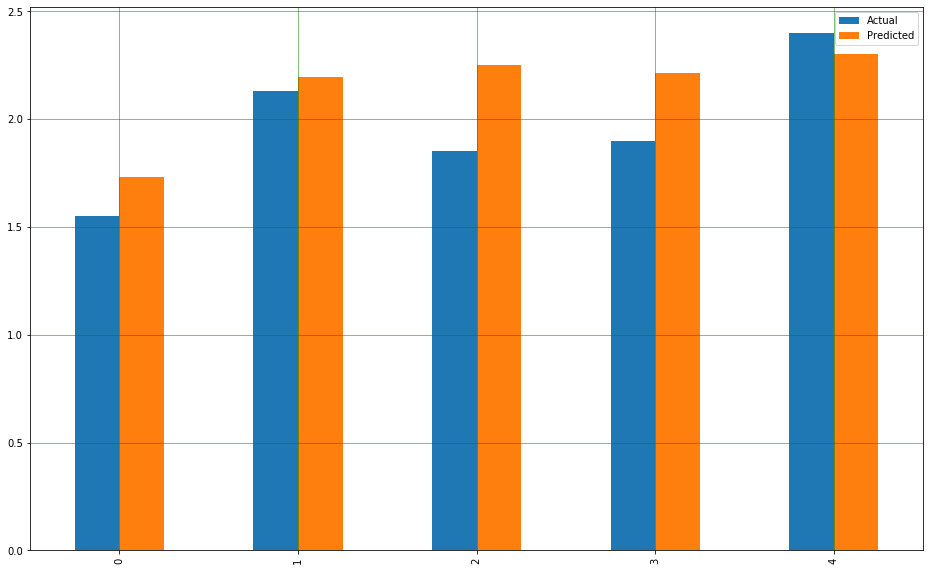

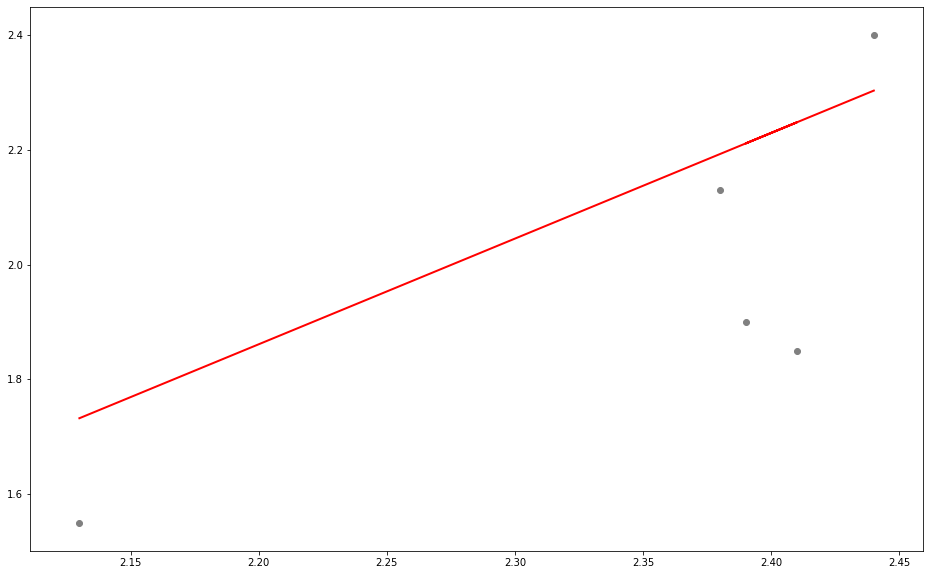

Mean Absolute Error: 0.21022695163919586
Mean Squared Error: 0.06036626191530371
Root Mean Squared Error: 0.24569546580127138
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              2009.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                    2.47e-22
Time:                        03:02:10   Log-Likelihood:                          3.0673
No. Observations:                  22   AIC:                                     -4.135
Df Residuals:                      21   BIC:                                     -3.044
Df Model:                           1                                                  
Covariance Type:            nonrobust                                             

,Actual,Predicted
0,1.55,1.732414
1,2.13,2.192775
2,1.85,2.248018
3,1.90,2.211190
4,2.40,2.303262


In [286]:

class InterestRate(FederalRates):
    
    def filtered(self):
        rawInterestRate = self.fundRate["DATE"] > "2019-04-15"
        return self.fundRate[rawInterestRate].set_index("DATE")
    
    def predict(self):
        interestRate = self.filtered()["FF"]    
        freqTable = dict(Counter(interestRate))
        return interestRate .describe()
    
    def testValues(self):
        data = sorted(self.filtered()["FF"], reverse=True)
        print(data)

        X = self.filtered()["FF"][:22].values.reshape(-1,1) 
        y = self.filtered()["FF"][10:].values.reshape(-1,1) 

 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)        
        
        reg = LinearRegression()
        reg.fit(X_train, y_train)

        t = sm.add_constant(X)
        
        
        #Calculating the coefficient for the data set, so define and retriving our slope 
        #and the intercept:
        coeff_df = pd.DataFrame([{"Coefficient":reg.coef_[0][0], "Intercept":reg.intercept_[0]}])
        

        
        y_pred = reg.predict(X_test)
        y_pred = reg.intercept_ + np.sum(reg.coef_ * X_test, axis=1)
        
        
        df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
        df1 = df.head(10)
        
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
        df2 = df.head(10)
        fig = plt.subplots(figsize=(16,10))
        plt.scatter(X_test, y_test,  color='gray')
        plt.plot(X_test, y_pred, color='red', linewidth=2)
        plt.show()
        
        print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
        print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
        print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
        print(sm.OLS(y, X).fit().summary())
        return df.head(10)

       
def predictInterestRate(rawInterestRateData):
    interestRate = InterestRate(FederalRates.readData(rawInterestRateData), 0)
    return interestRate.testValues()
predictInterestRate("./FF.csv")              

In [279]:
file = pd.read_csv("./index.csv")
rawInterestRate = file[["Effective Federal Funds Rate", "Inflation Rate"]]
data = rawInterestRate.fillna(0)

data.describe()


,Effective Federal Funds Rate,Inflation Rate
count,904.000000,904.00000
mean,4.085254,2.93219
std,3.771489,2.74817
min,0.000000,0.00000
25%,0.180000,1.20000
50%,3.715000,2.30000
75%,6.012500,4.30000
max,19.100000,13.60000


In [280]:
data

,Effective Federal Funds Rate,Inflation Rate
0,0.80,0.0
1,1.22,0.0
2,1.06,0.0
3,0.85,0.0
4,0.83,0.0
5,1.28,0.0
6,1.39,0.0
7,1.29,0.0
8,1.35,0.0
9,1.43,0.0


In [290]:
        X = data[:*8].values.reshape(-1,1) 
        y = data[*2:].values.reshape(-1,1) 
        
 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)        
        
        reg = LinearRegression()
        reg.fit(X_train, y_train)


        #Calculating the coefficient for the data set, so define and retriving our slope 
        #and the intercept:
        coeff_df = pd.DataFrame([{"Coefficient":reg.coef_[0][0], "Intercept":reg.intercept_[0]}])
        

        
        y_pred = reg.predict(X_test)
        y_pred = reg.intercept_ + np.sum(reg.coef_ * X_test, axis=1)
        
        
        df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
        df1 = df.head(25)
        
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
        df2 = df.head(25)
        fig = plt.subplots(figsize=(16,10))
        plt.scatter(X_test, y_test,  color='gray')
        plt.plot(X_test, y_pred, color='red', linewidth=2)
        plt.show()
        
        print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
        print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
        print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
        print(sm.OLS(y, X).fit().summary())
        df.head(25)

SyntaxError: invalid syntax (<ipython-input-290-2312568e8e60>, line 1)